In [47]:
import numpy as np  
import scipy
import matplotlib.pyplot as plt 

def fDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s), dtype=complex)
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (j * dx)**k / np.math.factorial(k)

    return mat 

def bDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s), dtype=complex)
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (-j * dx)**k / np.math.factorial(k)

    return mat 

def fDiffVec(order, f): 
    diff = np.zeros(order, dtype=complex)
    for j in range(1, order + 1):
        diff[j-1] = f[j] - f[0]
    return diff 

def bDiffVec(order, f): 
    diff = np.zeros(order, dtype=complex)
    for j in range(1, order + 1):
        diff[j-1] = (f[-1-j] - f[-1])
    return diff 


def iterativeRefinement(A, b, tolerance = 1e-9): 
    C = np.linalg.solve(A, b) 
    residual      = b - A @ C
    residualError = np.sum(np.abs(residual)) 

    iteration = 0
    while residualError > tolerance:
        correction = np.linalg.solve(A, residual) 
        C += correction
        residual = b - A @ C
        residualError = np.sum(np.abs(residual)) 
        iteration += 1
        #print(f"After {iteration} iterations with residual error {residualError}")
        if iteration > 100:
            break

    #print(f"Finished in {iteration} iterations with residual error {residualError}")
    return C 


def shiftx(x):
    return (x - x[0])/(x[-1] - x[0])

def planeWaveDiffVec(order, f, Dl, Dr):
    order = order + 1 # Account for Dirichlet BC
    b = np.zeros(2*order, dtype = complex) 
    b[0] = f[ 0]
    b[1] = f[-1]
    for i in range(1, order): 
        b[i*2    ] = Dl[i - 1]/(np.pi)**(i) 

    for i in range(1, order): 
        b[i*2 + 1] = Dr[i - 1]/(np.pi)**(i) 

    return b 

def planeWaveDiffMat(order): 
    order = order + 1 # Account for Dirichlet BC
    A = np.zeros((order*2, order*2), dtype=complex)
    for i in range(order): 
        for j in range(1, 2*order+1):
            #Every derivative gives a factor of j                                -- j**i
            #Every derivative gives an imaginary unit                            -- (i)**i 
            #Cosine evaluated at pi gives imaginary unit depending on wavelength -- (i)**j
            A[2*i  , j-1] = j**i * (1j)**i
            A[2*i+1, j-1] = j**i * (1j)**i * (-1)**j 

    return A

def reconstruct(C, x, derivative_order = 0):
    f     = np.zeros(x.shape, dtype=complex) 
    L     = x[-1] - x[0]
    xeval = shiftx(x) 
    
    for k in range(1, len(C) + 1):
        f += C[k-1] * (1j * k * np.pi / L) ** derivative_order * np.exp(1j * k * np.pi * xeval)

    return f




def getShiftFunction(f, order, x): 
    xeval = shiftx(x) 
    dx = xeval[1] - xeval[0]
    A = fDiffMat (order, dx) 
    b = fDiffVec (order, f)
    Dl = iterativeRefinement(A, b)

    A = bDiffMat (order, dx) 
    b = bDiffVec (order,  f)

    Dr = iterativeRefinement(A, b)


    A = planeWaveDiffMat(order) 
    b = planeWaveDiffVec(order, f, Dl, Dr)
    C = iterativeRefinement(A, b)

    shift = reconstruct(C, xeval)
    return shift, C, xeval

def getk(p, dx): 
    N = len(p) 
    L = len(p) * dx
    k = 2 * np.pi/ L * np.arange(-N/2, N/2)
    return np.fft.ifftshift(k) 

[] []
[[ 1.+0.j  1.+0.j]
 [-1.+0.j  1.+0.j]]
[1.        +0.j 2.71828183+0.j]
[-0.85914091+0.j  1.85914091+0.j]


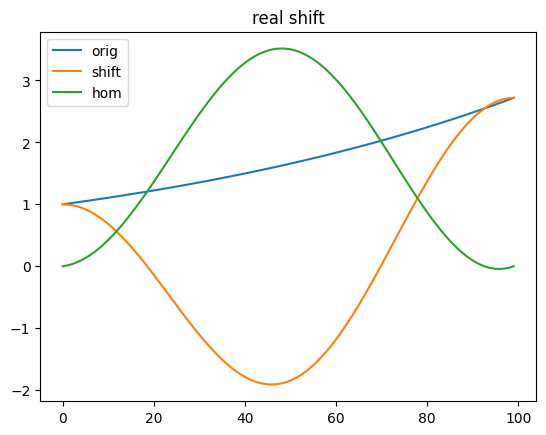

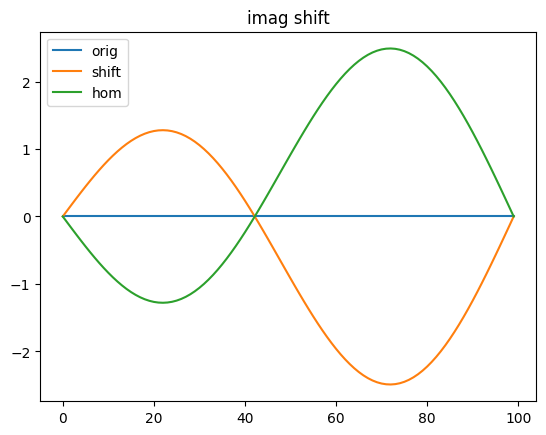

In [48]:


x     = np.linspace(0, 1, 100)
f     = np.exp(x)# + 1j * np.exp(x)
order = 0 
dx = x[1] - x[0]
A = fDiffMat (order, dx) 
b = fDiffVec (order, f)
Dl = iterativeRefinement(A, b)

A = bDiffMat (order, dx) 
b = bDiffVec (order,  f)
Dr = iterativeRefinement(A, b)

print(Dl, Dr)
A = planeWaveDiffMat(order) 
b = planeWaveDiffVec(order, f, Dl, Dr)
C     = iterativeRefinement(A, b)
shift = reconstruct(C, x) 
print(A) 
print(b)
print(C)

plt.title("real shift")
plt.plot(f.real, label="orig") 
plt.plot(shift.real, label="shift")
plt.plot(f.real - shift.real, label="hom")
plt.legend()
plt.show()
plt.title("imag shift")
plt.plot(f.imag, label="orig") 
plt.plot(shift.imag, label="shift")
plt.plot(f.imag - shift.imag, label="hom")
plt.legend()
plt.show()

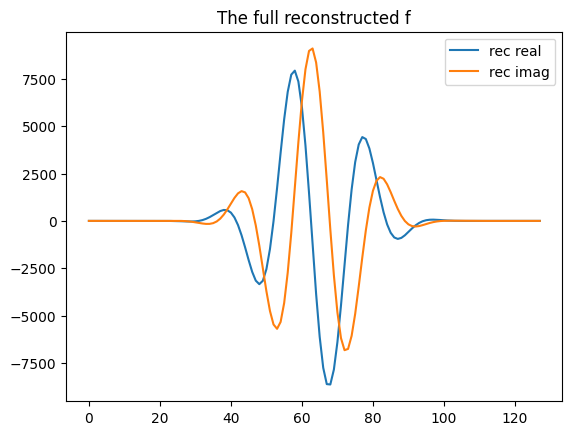

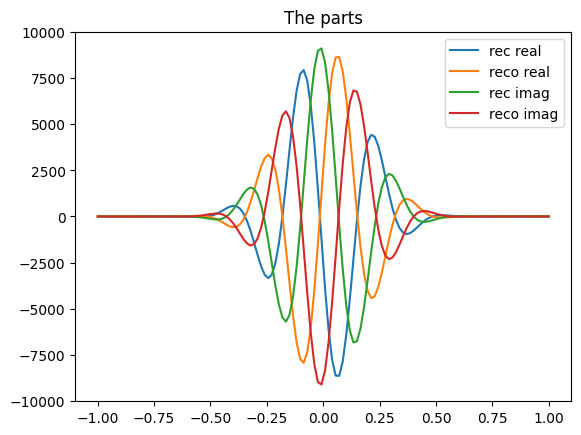

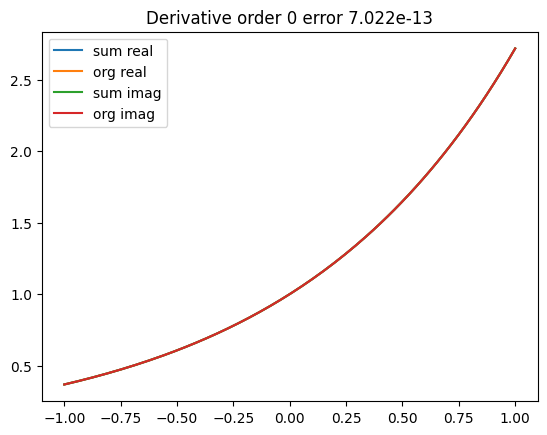

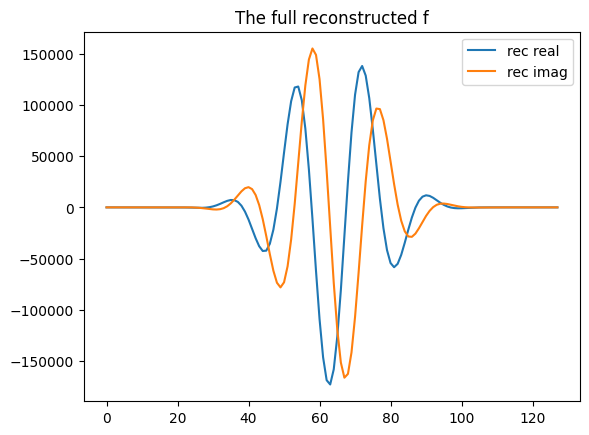

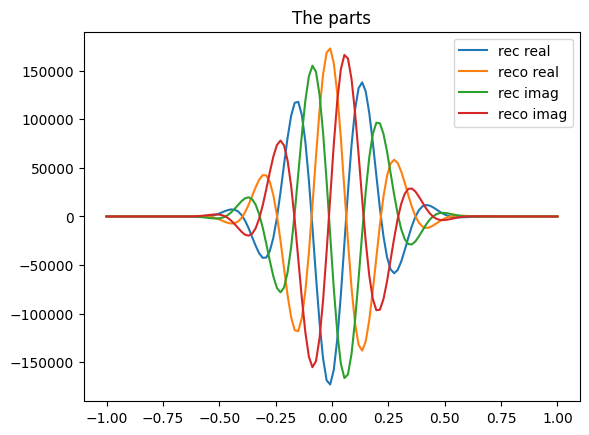

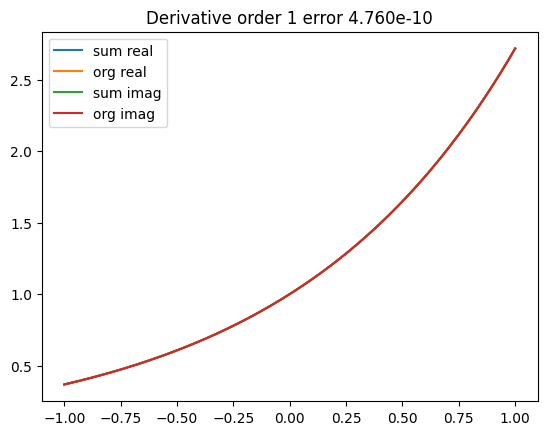

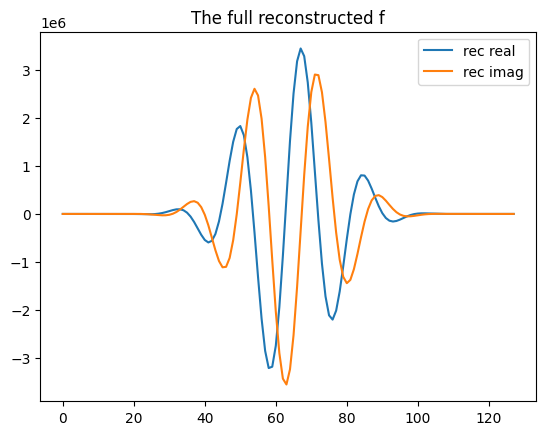

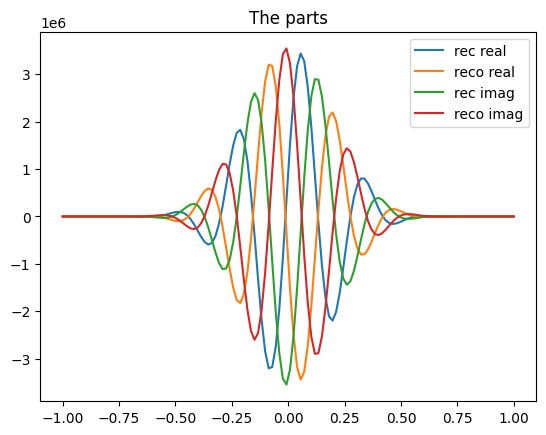

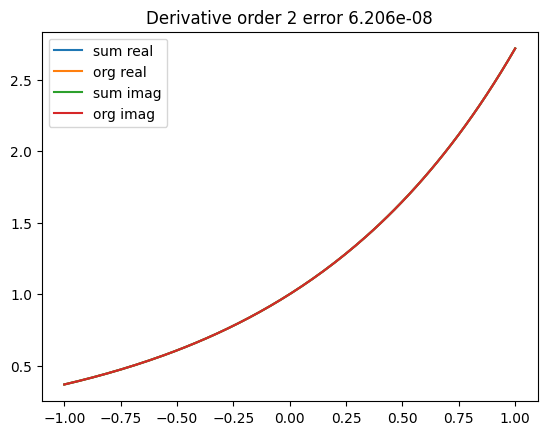

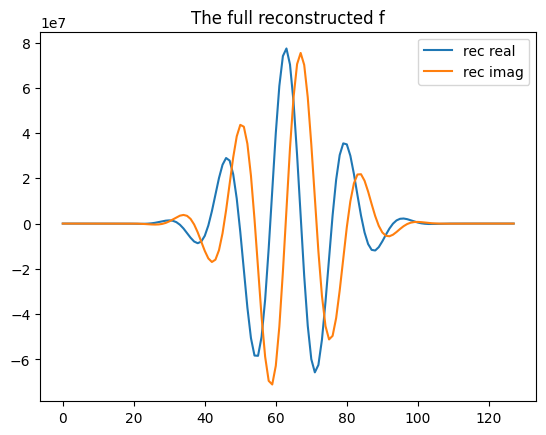

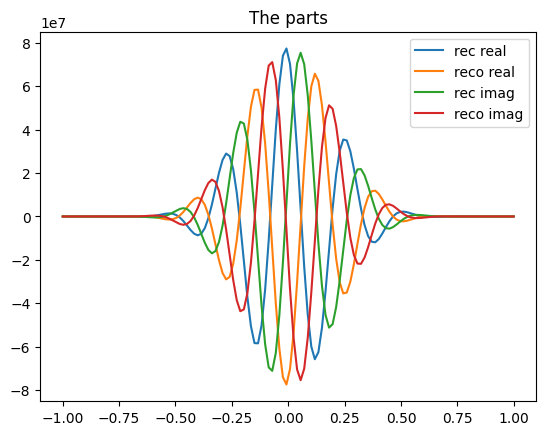

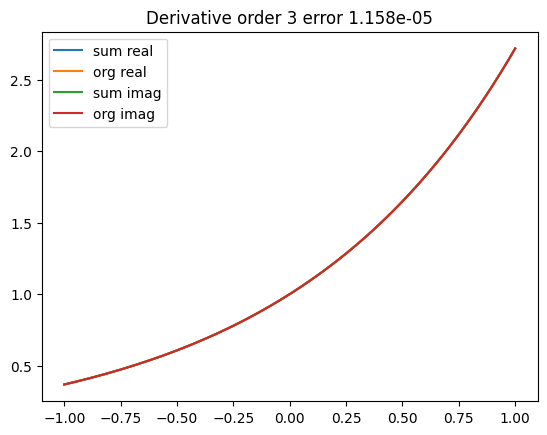

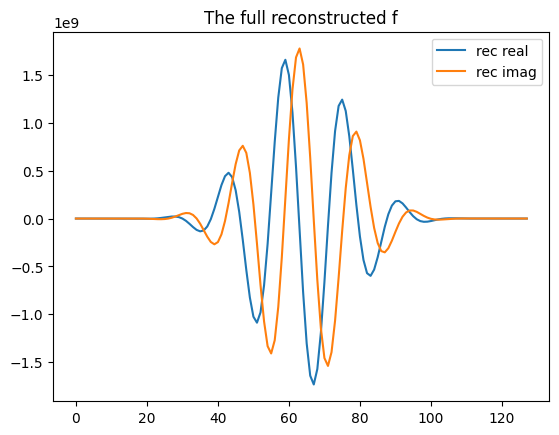

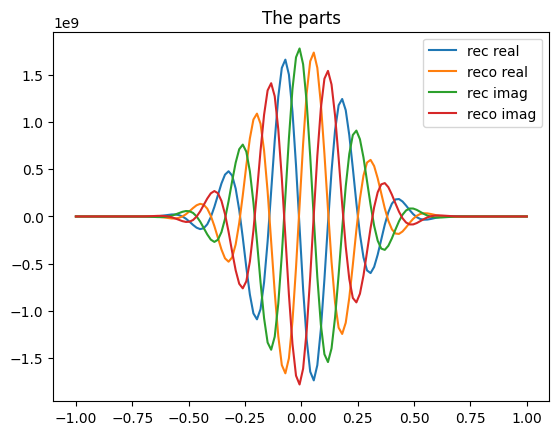

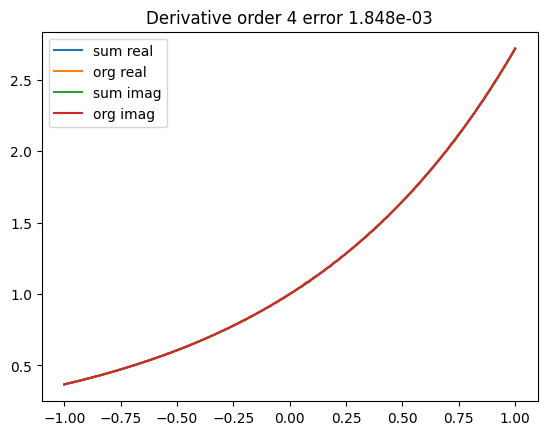

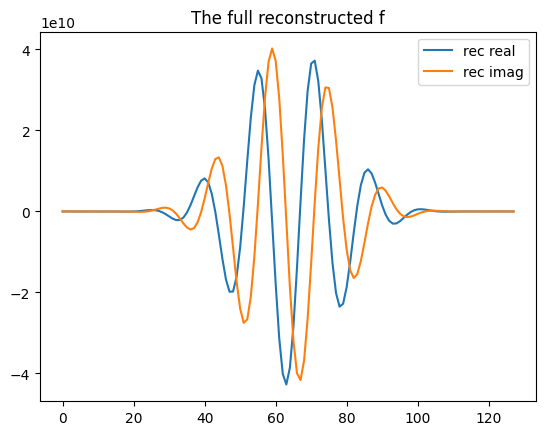

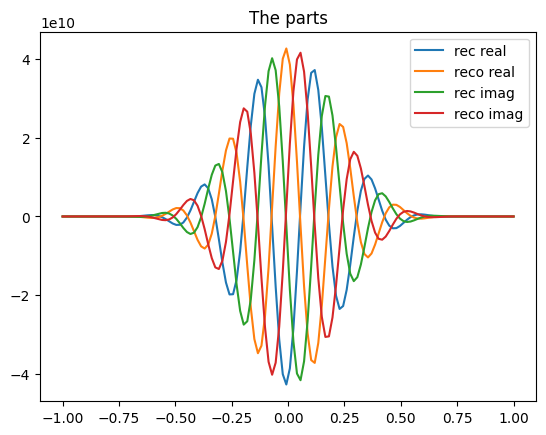

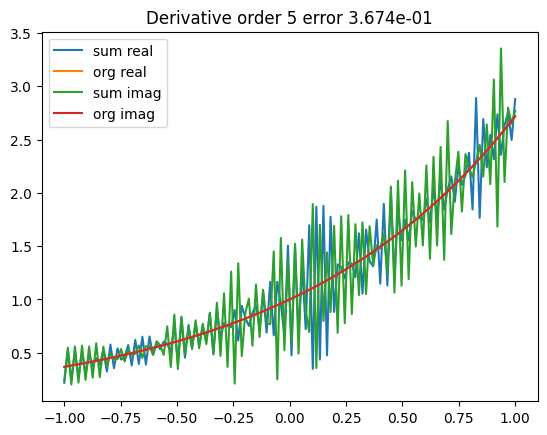

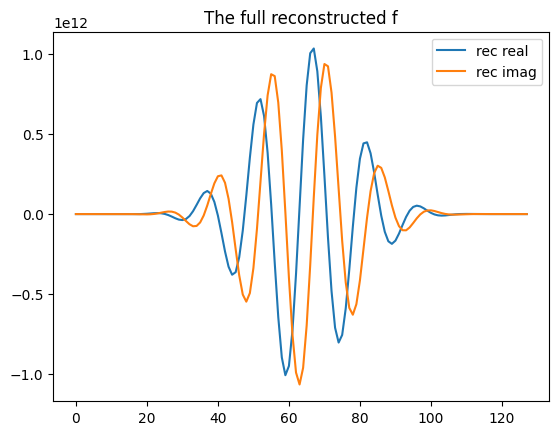

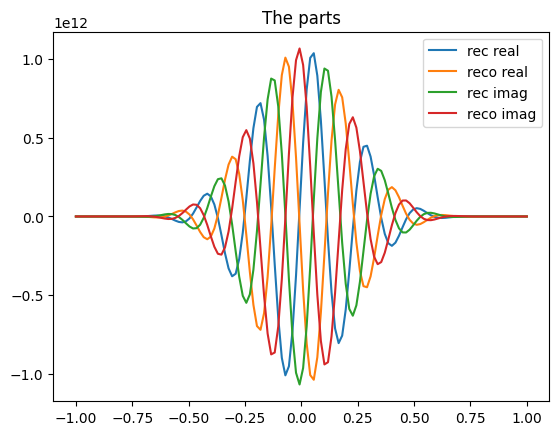

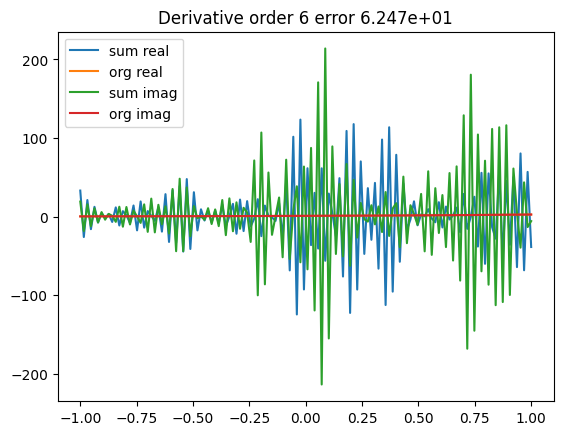

In [49]:
x = np.linspace(-1, 1, 128) 
dx = x[1] - x[0]
f = np.exp(x) + 1j * np.exp(x)
shift, C, xeval = getShiftFunction(f, 11, x) 
fhat = scipy.fft.fft(f - shift)

k = getk(fhat, dx) 

for i in range(7): 
    forg = np.exp(x) + 1j * np.exp(x) 
    frec = scipy.fft.ifft(fhat * (1j*k)**i)
    plt.title("The full reconstructed f")
    plt.plot(frec.real, label="rec real") 
    plt.plot(frec.imag, label="rec imag") 

    plt.legend()
    plt.show() 
    frec = frec
    reco = reconstruct(C, x, i)
    sumo = frec + reco 
    plt.title("The parts")
    plt.plot(x, frec.real, label="rec real") 
    plt.plot(x, reco.real, label="reco real") 
    plt.plot(x, frec.imag, label="rec imag") 
    plt.plot(x, reco.imag, label="reco imag") 

    plt.legend()
    plt.show() 
    plt.title(f"Derivative order {i} error {np.mean(np.abs(sumo-forg)):3.3e}")
    plt.plot(x, sumo.real, label="sum real") 
    plt.plot(x, forg.real, label="org real") 
    plt.plot(x, sumo.imag, label="sum imag") 
    plt.plot(x, forg.imag, label="org imag") 
    plt.legend()
    plt.show() 

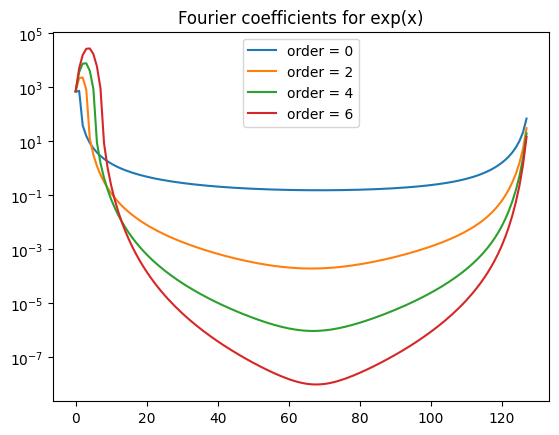

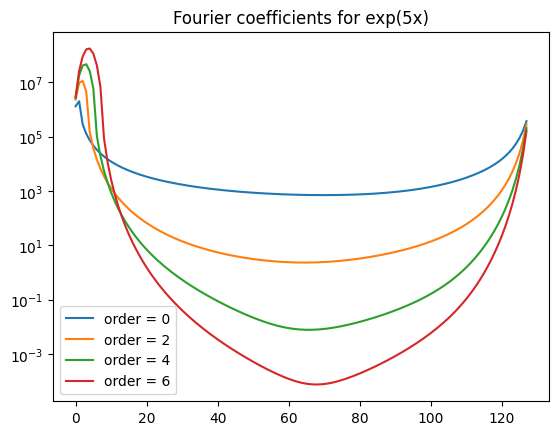

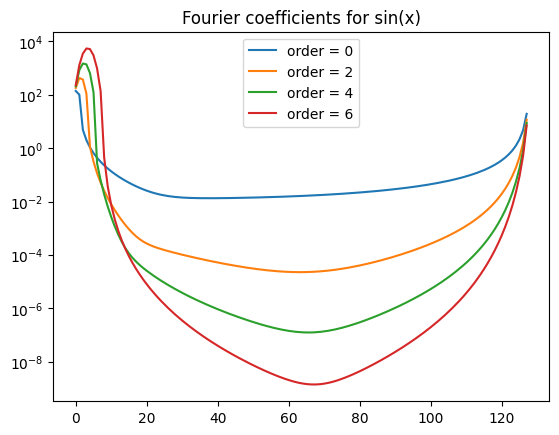

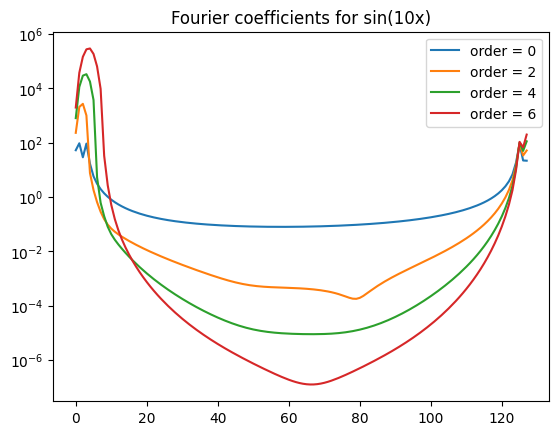

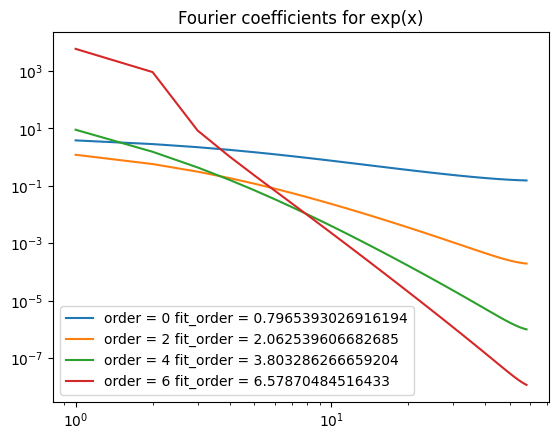

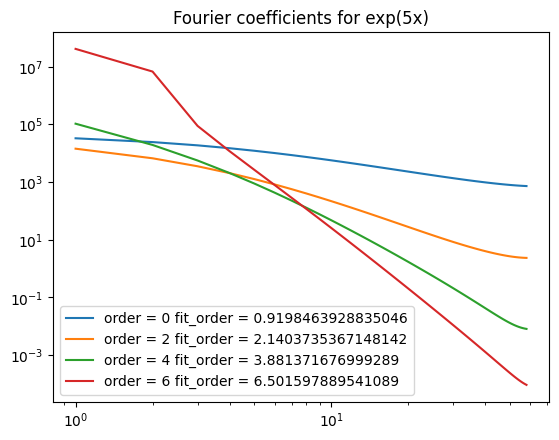

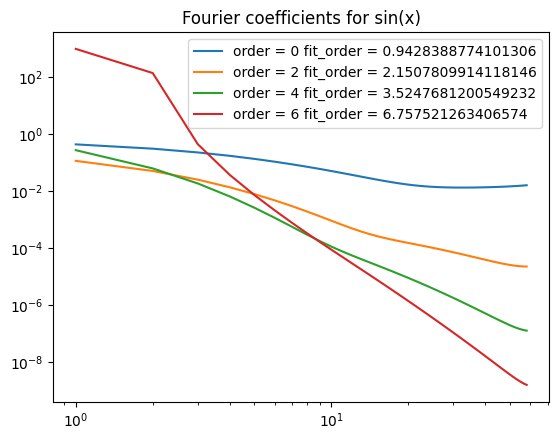

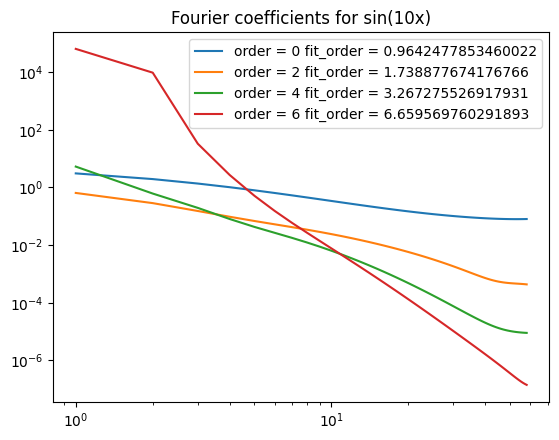

In [51]:

x = np.linspace(0, 2, 128)
fs = [np.exp(x) + 1j * np.exp(x), np.exp(5*x) + 1j * np.exp(5*x), np.sin(x) + 1j * np.sin(x) , np.sin(x*10) + 1j * np.sin(x*10)]
ns = ["exp(x)", "exp(5x)", "sin(x)", "sin(10x)"]

for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    plt.yscale("log") 
    for order in [0, 2, 4, 6]: 
        shift, C, xeval = getShiftFunction(f, order, x)
        hom = f - shift
        fhat = scipy.fft.fft(hom) 
        plt.plot(np.abs(fhat), label=f"order = {order}") 
    plt.legend()
    plt.show() 


for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    for order in [0, 2, 4, 6]: 
        shift, C, xeval = getShiftFunction(f, order, x)
        hom = f - shift 
        fhat = scipy.fft.fft(hom) 
        y    = np.abs(fhat)[6:int(len(fhat)/2)]
        r    = np.arange(1, len(y)+1)
        #print(len(y), len(r))
        def fitfunc(x, beta): 
            return np.log(y[0]) + beta * np.log(x)
        coeff, cov = scipy.optimize.curve_fit(fitfunc, r, np.log(y)) 
        #print(coeff)
        plt.loglog(r, y, label=f"order = {order} fit_order = {np.abs(coeff[0])}") 
        #plt.loglog(r, np.exp(fitfunc(r, coeff[0])), label=f"fit with {y[0]} * x ** {coeff[0]}") 
    plt.legend()
    plt.show() 